In [1]:
!pip3 install face_recognition

     |████████████████████████████████| 100.2MB 42kB/s 
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566172 sha256=b4ef58fd5705025c0081f6c7bf51663184636dd88ea9af6ec7081bac3e9b768c
  Stored in directory: /root/.cache/pip/wheels/d2/99/18/59c6c8f01e39810415c0e63f5bede7d83dfb0ffc039865465f
Successfully built face-recognition-models


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
%cd /content/drive/My\ Drive/DeepLearning/FaceNet

In [ ]:
import cv2 
import os 
import numpy as np 
from face_recognition import face_locations, load_image_file
import glob 
import pickle

In [ ]:
def loadModel(model_path):
    # Model was trained on PyTorch 
    # So we must load model to openCV 
    model = cv2.dnn.readNetFromTorch(model_path)
    return model

In [ ]:
# Convert original image to blob image to reduce noise for photo due to lighting 
def blobImage(img, scale_factor=1.0, size=(300, 300), mean=(104.0, 177.0, 123.0)):
    # Use bloFromImages for batches, load and process multiple images
    imageBlob = cv2.dnn.blobFromImage(img, scalefactor=scale_factor, 
                                    size=size, mean=mean, swapRB=False)
    return imageBlob

In [ ]:
def faceRecognition(img_path, single=True):
    img = load_image_file(img_path)
    faces = face_locations(img)
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    name = img_path.split('/')[-2]
    if name not in labels:
        labels.append(name)
    label = labels.index(name)
    if len(faces) == 0:
        return None, -1 
    elif single:
        (top, right, bottom, left) = faces[0]
        face = img[top:bottom, left:right].copy()
        return face, label
    else:
         return faces, label

In [ ]:
def savePickle(obj, path):
    with open(path, 'wb') as f:
        pickle.dump(obj, f)

def loadPickle(path):
    with open(path, 'rb') as f:
        obj = pickle.load(f)
    return obj 

In [10]:
imgs_path = glob.glob('./Dataset/*/*.jpg')

labels = []
print(f"Number of images : {len(imgs_path)}")
num = 0; all_faces = []
all_links = []; all_labels = []
for img_path in imgs_path:
    out, label = faceRecognition(img_path)
    if out is None:
        print(f"Failed to detect face in {img_path}")
    else:
        num += 1 
        all_faces.append(out)
        all_labels.append(label)
        all_links.append(img_path)

Number of images : 145
Failed to detect face in ./Dataset/baejun/022.jpg
Failed to detect face in ./Dataset/baejun/021.jpg
Failed to detect face in ./Dataset/sontung/011.jpg
Failed to detect face in ./Dataset/sontung/008.jpg
Failed to detect face in ./Dataset/sontung/016.jpg
Failed to detect face in ./Dataset/sontung/015.jpg
Failed to detect face in ./Dataset/sontung/030.jpg
Failed to detect face in ./Dataset/thaotam/019.jpg


In [11]:
# Use pretrain to get embedding vectors from images
def embeddingFaces(encoder, faces):
    embed_vecs = []
    for face in faces:
        faceBlob = blobImage(face, size=(96, 96), scale_factor=1/255.0, mean=(0, 0, 0))
        encoder.setInput(faceBlob)
        vec = encoder.forward()
        embed_vecs.append(vec)
    return embed_vecs

model = loadModel('./nn4.small2.v1.t7')
embed_faces = embeddingFaces(model, all_faces)
embed_faces[0].shape

(1, 128)

In [12]:
savePickle(all_faces, './Dataset/faces.pkl')
savePickle(all_labels, './Dataset/labels.pkl')
savePickle(all_links, './Dataset/links.pkl')
savePickle(embed_faces, './Dataset/embed_faces.pkl')

In [13]:
from sklearn.model_selection import train_test_split

ids = np.arange(len(all_faces))
X_train, X_test, y_train, y_test, ids_train, ids_test = train_test_split(np.stack(embed_faces), all_labels, 
                                                                         ids, test_size=0.2, stratify=all_labels)
X_train = np.squeeze(X_train, axis=1)
X_test = np.squeeze(X_test, axis=1)

In [14]:
print(f"Number of training data : {len(X_train)}")
print(f"Number of testing data : {len(X_test)}")

Number of training data : 109
Number of testing data : 28


In [15]:
savePickle(ids_train, './Dataset/ids_train.pkl')
savePickle(ids_test, './Dataset/ids_test.pkl')

In [16]:
from sklearn.metrics.pairwise import cosine_similarity

def k_most_similarity(X, vec, y, k):
    simi = cosine_similarity(X, vec)
    simi = simi.squeeze(1)
    ids = simi.argsort()[-k:][::-1]
    counts = np.zeros_like(labels, dtype=int)
    for idx in ids:
        counts[y[idx]] += 1
    return counts.argmax()
#     idx = simi.argmax()
#     return y[idx]

vec = X_test[1].reshape(1, -1)
print(k_most_similarity(X_train, vec, y_train, 1))

2


In [17]:
print(X_test[1])

[ 0.02251976  0.10552192  0.10714176  0.08971821  0.01856488  0.08795888
  0.05518661  0.01343364 -0.02740365 -0.08234629  0.0325595   0.03701751
 -0.00427227 -0.1361044  -0.08500305 -0.06264268 -0.13310866  0.1073085
 -0.07427181  0.01683343  0.22655666 -0.10062084  0.02732531 -0.106806
  0.08942548 -0.17622802 -0.21330151 -0.06334433 -0.03951249  0.10689468
  0.00828004 -0.08736766 -0.01803419  0.02692922  0.11138184 -0.11568782
 -0.03867543 -0.00422776  0.09485707 -0.08697245 -0.03114068 -0.00571464
  0.08112915 -0.00458275 -0.07291388 -0.19733523  0.05450888 -0.13042583
 -0.04374429  0.11196988  0.02350123  0.0215595  -0.07428126  0.11956836
 -0.00503961 -0.03633654  0.04540662 -0.08295524 -0.12188653 -0.08302956
  0.04006799 -0.03313868  0.04546786 -0.09082938  0.07494271 -0.05190376
 -0.00615339 -0.10070471 -0.11946141  0.0320025   0.09759552  0.09360118
  0.01395929  0.00897024 -0.10217157  0.00638379  0.00153291 -0.12202484
  0.03155127  0.11335555 -0.12863746 -0.04713567  0.09

In [18]:
all_faces = loadPickle('./Dataset/faces.pkl')
all_labels = loadPickle('./Dataset/labels.pkl')
all_links = loadPickle('./Dataset/links.pkl')
embed_faces = loadPickle('./Dataset/embed_faces.pkl')
ids_train = loadPickle('./Dataset/ids_train.pkl')
ids_test = loadPickle('./Dataset/ids_test.pkl')

X_train = []; X_test = []
y_train = []; y_test = []

for idx in ids_train:
    X_train.append(embed_faces[idx])
    y_train.append(all_labels[idx])
for idx in ids_test:
    X_test.append(embed_faces[idx])
    y_test.append(all_labels[idx])

X_train, X_test = np.stack(X_train), np.stack(X_test)
X_train, X_test = X_train.squeeze(1), X_test.squeeze(1)

In [19]:
print(X_test[1])

[ 0.02251976  0.10552192  0.10714176  0.08971821  0.01856488  0.08795888
  0.05518661  0.01343364 -0.02740365 -0.08234629  0.0325595   0.03701751
 -0.00427227 -0.1361044  -0.08500305 -0.06264268 -0.13310866  0.1073085
 -0.07427181  0.01683343  0.22655666 -0.10062084  0.02732531 -0.106806
  0.08942548 -0.17622802 -0.21330151 -0.06334433 -0.03951249  0.10689468
  0.00828004 -0.08736766 -0.01803419  0.02692922  0.11138184 -0.11568782
 -0.03867543 -0.00422776  0.09485707 -0.08697245 -0.03114068 -0.00571464
  0.08112915 -0.00458275 -0.07291388 -0.19733523  0.05450888 -0.13042583
 -0.04374429  0.11196988  0.02350123  0.0215595  -0.07428126  0.11956836
 -0.00503961 -0.03633654  0.04540662 -0.08295524 -0.12188653 -0.08302956
  0.04006799 -0.03313868  0.04546786 -0.09082938  0.07494271 -0.05190376
 -0.00615339 -0.10070471 -0.11946141  0.0320025   0.09759552  0.09360118
  0.01395929  0.00897024 -0.10217157  0.00638379  0.00153291 -0.12202484
  0.03155127  0.11335555 -0.12863746 -0.04713567  0.09

In [20]:
from sklearn.metrics import accuracy_score 

def results(k_most, vecs_train, vecs_pred):
  y_preds = []
  for vec in vecs_pred:
      vec = vec.reshape(1, -1)
      y_pred = k_most_similarity(vecs_train, vec, y_train, k_most)
      y_preds.append(y_pred)

  return accuracy_score(y_preds, y_test)

print(f"The accuracy of selecting one most similar vectors : {results(1, X_train, X_test)}")
print(f"The accuracy of selecting five most similar vectors : {results(5, X_train, X_test)}")
print(f"The accuracy of selecting ten most similar vectors : {results(10, X_train, X_test)}")

The accuracy of selecting one most similar vectors : 0.5714285714285714
The accuracy of selecting five most similar vectors : 0.6428571428571429
The accuracy of selecting ten most similar vectors : 0.6428571428571429


In [ ]:
################################################################################
#     USE VGG19 TO FEATURE ENGINEERING EXTRACT 128 VECTORS                     #
################################################################################

In [21]:
!pip3 install keras
!pip3 install tensorflow

In [33]:
from tensorflow.keras.layers import Dense, Flatten, Lambda
from tensorflow.keras.models import Model 
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam 
import tensorflow as tf
def build_model():
    model = VGG16(include_top=True, weights=None)
    dense = Dense(128)(model.layers[-4].output)
    norm2 = Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(dense)
    model = Model(inputs=[model.input], outputs=[norm2])
    return model 

model = build_model()
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [34]:
def resize_image(faces):
    face_rs = []
    for face in faces:
        face = cv2.resize(face, dsize=(224, 224))
        face_rs.append(face)
    return face_rs 

all_faces = loadPickle('./Dataset/faces.pkl')
all_faces = resize_image(all_faces)

In [24]:
!pip3 install tensorflow_addons

In [35]:
import tensorflow_addons as tfa 
model.compile(optimizer=Adam(0.001),
             loss=tfa.losses.TripletSemiHardLoss())

In [36]:
all_faces = np.stack(all_faces)
all_faces.shape

(137, 224, 224, 3)

In [38]:
ids_train = loadPickle('./Dataset/ids_train.pkl')
ids_test = loadPickle('./Dataset/ids_test.pkl')

all_labels = loadPickle('./Dataset/labels.pkl')
all_labels = np.array(all_labels)
# X_train = all_faces[ids_train]/127.5 - 1
# X_test = all_faces[ids_test]/127.5 -1
X_train = all_faces[ids_train]
X_test = all_faces[ids_test]

y_train = all_labels[ids_train]
y_test = all_labels[ids_test]

In [39]:
X_train.shape

(109, 224, 224, 3)

In [40]:
gen_train = tf.data.Dataset.from_tensor_slices((X_train, y_train)).repeat().shuffle(1024).batch(32)

In [41]:
# history = model.fit(X_train, y_train, batch_size=1, epochs=50)
history = model.fit(
    gen_train,
    steps_per_epoch = 50,
    epochs=10)

Epoch 1/10
50/50 [==============================] - 39s 776ms/step - loss: 0.9540
Epoch 2/10
50/50 [==============================] - 39s 776ms/step - loss: 0.9022
Epoch 3/10
50/50 [==============================] - 39s 776ms/step - loss: 0.7861
Epoch 4/10
50/50 [==============================] - 39s 775ms/step - loss: 0.5912
Epoch 5/10
50/50 [==============================] - 39s 776ms/step - loss: 0.3023
Epoch 6/10
50/50 [==============================] - 39s 772ms/step - loss: 0.0628
Epoch 7/10
50/50 [==============================] - 38s 766ms/step - loss: 0.0019
Epoch 8/10
50/50 [==============================] - 38s 764ms/step - loss: 3.1872e-06
Epoch 9/10
50/50 [==============================] - 38s 764ms/step - loss: 0.0000e+00
Epoch 10/10
50/50 [==============================] - 38s 764ms/step - loss: 0.0000e+00


In [42]:
vecs_train = model.predict(X_train)
vecs_pred = model.predict(X_test)

In [43]:
print(f"The accuracy of selecting one most similar vectors : {results(1, vecs_train, vecs_pred)}")
print(f"The accuracy of selecting five most similar vectors : {results(5, vecs_train, vecs_pred)}")
print(f"The accuracy of selecting ten most similar vectors : {results(10, vecs_train, vecs_pred)}")

The accuracy of selecting one most similar vectors : 0.5714285714285714
The accuracy of selecting five most similar vectors : 0.5714285714285714
The accuracy of selecting ten most similar vectors : 0.5714285714285714


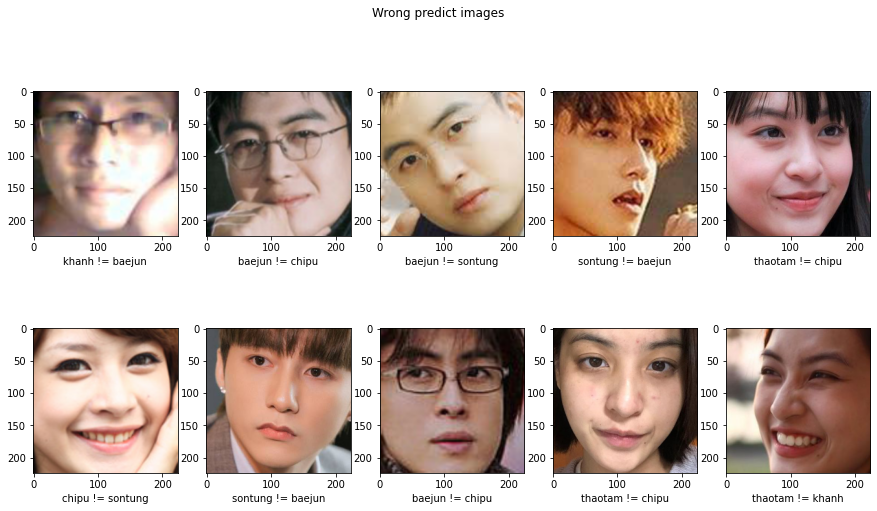

In [45]:
import matplotlib.pyplot as plt

y_preds = []
for vec in vecs_pred:
    vec = vec.reshape(1, -1)
    y_pred = k_most_similarity(vecs_train, vec, y_train, 1)
    y_preds.append(y_pred)

idx_diff = np.flatnonzero(np.array(y_preds) != np.array(y_test))

fg, ax = plt.subplots(2, 5, figsize=(15, 8))
fg.suptitle('Wrong predict images')

# imgs = np.array((X_test+1)*127.5, dtype=int)

for i in np.arange(2):
  for j in np.arange(5):
    ax[i, j].imshow(X_test[idx_diff[i*5+j]])
    ax[i, j].set_xlabel(f'{labels[y_test[idx_diff[i*5+j]]]} != {labels[y_preds[idx_diff[i*5+j]]]}')
    # ax[i, j].axis('off')

In [ ]:
###############################################################################
#                     USE DATA AUGMENTATION                                   #
###############################################################################

In [46]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

datagen.fit(X_train)

In [47]:
no_batch = 0
X_au = []
y_au = []
for i in np.arange(len(X_train)):
  no_img = 0
  for x in datagen.flow(np.expand_dims(X_train[i], axis = 0), batch_size = 1):
    X_au.append(x[0])
    y_au.append(y_train[i])
    no_img += 1
    if no_img == 5:
      break

In [48]:
import tensorflow_addons as tfa
model2 = build_model()

model2.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tfa.losses.TripletSemiHardLoss())

In [49]:
gen_train2 = tf.data.Dataset.from_tensor_slices((X_au, y_au)).repeat().shuffle(1024).batch(64)
gen_train2

<BatchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int32)>

In [50]:
history = model2.fit(
    gen_train2,
    steps_per_epoch = 50,
    epochs=20)

Epoch 1/20
50/50 [==============================] - 81s 2s/step - loss: 0.9423
Epoch 2/20
50/50 [==============================] - 81s 2s/step - loss: 0.9262
Epoch 3/20
50/50 [==============================] - 81s 2s/step - loss: 0.9108
Epoch 4/20
50/50 [==============================] - 81s 2s/step - loss: 0.8948
Epoch 5/20
50/50 [==============================] - 81s 2s/step - loss: 0.8615
Epoch 6/20
50/50 [==============================] - 81s 2s/step - loss: 0.8010
Epoch 7/20
50/50 [==============================] - 81s 2s/step - loss: 0.7153
Epoch 8/20
50/50 [==============================] - 81s 2s/step - loss: 0.6703
Epoch 9/20
50/50 [==============================] - 81s 2s/step - loss: 0.5491
Epoch 10/20
50/50 [==============================] - 81s 2s/step - loss: 0.4070
Epoch 11/20
50/50 [==============================] - 81s 2s/step - loss: 0.3664
Epoch 12/20
50/50 [==============================] - 80s 2s/step - loss: 0.1872
Epoch 13/20
50/50 [==============================

In [51]:
data_tf = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    # width_shift_range=0.2,
    # height_shift_range=0.2,
    horizontal_flip=True
    )

data_tf.fit(X_test)

no_batch = 0
X_test_tf = []
for i in np.arange(len(X_test)):
  no_img = 0
  for x in data_tf.flow(np.expand_dims(X_test[i], axis = 0), batch_size = 1):
    X_test_tf.append(x[0])
    no_img += 1
    if no_img == 1:
      break

In [53]:
vecs_train = model2.predict(np.stack(X_au))
vecs_pred = model2.predict(np.stack(X_test_tf))

In [54]:
def results(k_most, vecs_train, vecs_pred):
  y_preds = []
  for vec in vecs_pred:
      vec = vec.reshape(1, -1)
      y_pred = k_most_similarity(vecs_train, vec, y_au, k_most)
      y_preds.append(y_pred)

  return accuracy_score(y_preds, y_test)

In [55]:
print(f"The accuracy of selecting one most similar vectors : {results(1, vecs_train, vecs_pred)}")
print(f"The accuracy of selecting five most similar vectors : {results(5, vecs_train, vecs_pred)}")
print(f"The accuracy of selecting ten most similar vectors : {results(10, vecs_train, vecs_pred)}")

The accuracy of selecting one most similar vectors : 0.6071428571428571
The accuracy of selecting five most similar vectors : 0.6071428571428571
The accuracy of selecting ten most similar vectors : 0.6071428571428571
